# BLR

Study of deconvolution algorithms

In [1]:
from __future__ import print_function
from IPython.display import Image
%matplotlib inline

In [5]:
import logging
import sys
logger = logging.getLogger()
logger.handlers[0].stream = sys.stdout
logger.setLevel(logging.DEBUG)

In [6]:
import pandas as pd
import tables as tb
import numpy as np
import tables

In [7]:
from system_of_units import *

In [8]:
import FEParam as FP
import SPE as SP
import FEE2 as FE
from scipy import signal as SGN 

In [9]:
from Configure import configure
from cities import isidora

In [10]:
%load_ext autoreload
%autoreload 2

In [11]:
import mplFunctions as mpl
import wfmFunctions as wfm
import tblFunctions as tbl

In [12]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

In [13]:
%load_ext Cython

In [26]:
%%cython

import numpy as np
cimport numpy as np
from scipy import signal as SGN 



cpdef BLRc(np.ndarray[np.int16_t, ndim=1] signal_daq, float coef, int nm, float thr):

    """
    cython version of VH function

    """

    cdef int len_signal_daq = len(signal_daq)
    cdef np.ndarray[np.float64_t, ndim=1] MAU = np.zeros(len_signal_daq, dtype=np.double)
    cdef np.ndarray[np.float64_t, ndim=1] acum = np.zeros(len_signal_daq, dtype=np.double)
    cdef np.ndarray[np.float64_t, ndim=1] signal_r = np.zeros(len_signal_daq, dtype=np.float64)
    
    cdef np.ndarray[np.float64_t, ndim=1] B_MAU       =   (1./nm)*np.ones(nm)

#   MAU averages the signal in the initial tranch 
#    allows to compute the baseline of the signal  
    
    MAU[0:nm] = SGN.lfilter(B_MAU, 1, signal_daq[0:nm])
    acum[nm] =  MAU[nm]
    cdef float BASELINE = MAU[nm-1]
    print('baseline = {}'.format(BASELINE))

    signal_r[0:nm] = signal_daq[0:nm] 

    # MAU has computed the offset using nm samples
    # now loop until the end of DAQ window
        
    cdef int pulse_on = 0
    cdef int k, j
    cdef float offset = 0, part_sum 
    for k in range(nm,len_signal_daq): 
        
        trigger_line = MAU[k-1] + thr
        if k%1000 == 0 or k < 510:
            print('k = {} trigger_line = {} pulse_on = {} MAU = {} signal_d = {} signal_r = {}'.format(k,
                                                                                        trigger_line,
                                                                                        pulse_on,
                                                                                        MAU[k-1],
                                                                                        signal_daq[k],
                                                                                        signal_r[k-1]))

        # condition: raw signal raises above trigger line 
        if (signal_daq[k] > trigger_line) or pulse_on == 1:
            if pulse_on == 0:
                pulse_on = 1
                #offset computed as the value of MAU before pulse starts
                #offset = MAU[k-1] 
                
                print('trigger at k = {}, MAU = {} offset = {}, accum = {}'.format(k, MAU[k-1], offset, acum[k-1]))
                print('k = {} trigger_line = {} pulse_on = {} MAU = {} signal_d = {} signal_r = {}'.format(k,
                                                                                        trigger_line,
                                                                                        pulse_on,
                                                                                        MAU[k-1],
                                                                                        signal_daq[k],
                                                                                        signal_r[k-1]))
            if k%100 == 0:
                print('k = {} trigger_line = {} pulse_on = {} MAU = {} signal_d = {} signal_r = {}'.format(k,
                                                                                        trigger_line,
                                                                                        pulse_on,
                                                                                        MAU[k-1],
                                                                                        signal_daq[k],
                                                                                        signal_r[k-1]))



            MAU[k] = MAU[k-1] # MAU is frozen
            
            #update recovered signal, correcting by offset           
            #acum[k] = acum[k-1] + signal_daq[k] - offset;
            #signal_r[k] = signal_daq[k] + coef*acum[k]
            
            signal_r[k] = signal_daq[k] + signal_daq[k]*(coef/2.0) + coef*acum[k-1] 
            acum[k] = acum[k-1] + signal_daq[k] - BASELINE;
            
            #if pulse_on == 1:
            #    if signal_r[k] < trigger_line + thr2:
            #        pulse_on = 0   #recovered pulse is over
            
        elif pulse_on == 0: #update MAU
                    
            part_sum = 0.
            for j in range(k-nm, k): 
                part_sum += signal_daq[j]
            part_sum /=nm
            MAU[k] = part_sum
            acum[k] = MAU[k-1]
            signal_r[k] = signal_daq[k]
            
            if k == 500:
                print(k,nm,k-nm,part_sum,sum(signal_daq[0:500])/nm, sum(signal_daq[0:500]/(nm-1.)))
        else:
            print('***below trigger line: k = {}, trigger = {} signal_daq = {}, signal_rec = {} '.format(k, trigger_line,
                                                                                          signal_daq[k],
                                                                                          signal_r[k]))
            
                
                       
    print('baseline = {} offset = {}'.format(BASELINE, offset))
    return  signal_r - BASELINE, MAU




### ISIDORA

In [18]:
# %load ../../../Cities/ISIDORA.py
"""
ISIDORA
JJGC Agusut 2016

What ISIDORA does:
1) Reads a RWF file written by DIOMIRA
2) Performs DBLR
3) Write the corrected waveforms (CWF) to the file as new Evectors.

Change Log:
18/10 JJG added cython module
"""

from __future__ import print_function

import sys
from time import time
import numpy as np
import tables

import system_of_units as units
from LogConfig import logger
from Configure import configure, define_event_loop

import FEParam as FP
import FEE2 as FE
import coreFunctions as cf


def accumulator_coefficients(CA,NPMT,len_WF):
    """
    Compute the accumulator coefficients for DBLR
    It computes the inverse function of the HPF and takes
    the accumulator as the value of the function anywhere
    but the first bin (the inverse is a step function with
    constant value equal to the accumulator)
    CA are the values of the capacitances defining the filter
    (1/(2CR)) for each PMT
    """
    coef_acc = np.zeros(NPMT, dtype=np.double)

    signal_t = np.arange(0.0, len_WF*1., 1., dtype=np.double)

    for j in range(NPMT):
        fee = FE.FEE(C=CA[j], R=FP.R, f=FP.freq_LPF, RG=FP.V_GAIN)
        signal_inv_daq = fee.InverseSignalDAQ(signal_t)  # inverse function
        coef_acc[j] = signal_inv_daq[10] # any index is valid, function is flat

    return coef_acc


def DBLR(pmtrd, event_number, coeff_acc, mau_len=250,
         thr1 = FP.NOISE_ADC, thr2=0, thr3 = FP.NOISE_ADC):
    """
    Peform Base line Restoration
    coeff_acc is an array with the coefficients of the accumulator
    Threshold 1 is used to decide when raw signal raises up above trigger line
    Threshold 2 is used to decide when reconstructed signal is above trigger line
    Threshold 3 is used to compare Raw and Rec signal
    """

    len_WF = pmtrd.shape[2]
    NPMT = pmtrd.shape[1]
    BLRS =[]

    for j in range(NPMT):
        sgn_raw = FP.ceiling - pmtrd[event_number, j]
        sgn_rec, MAU = BLRc(sgn_raw, coeff_acc[j], mau_len, thr1)
        BLRS.append(sgn_rec)
        
    return np.array(BLRS)


def ISIDORA(argv):
    DEBUG_LEVEL, INFO, CFP = configure(argv[0],argv[1:])

    if INFO:

        print("""
        ISIDORA:
        1. Reads an Nh5 file produced by DIOMIRA, which stores the
            raw waveforms (RWF) for the PMTs and SiPMs waveforms, as well as
            data on geometry, sensors and MC. The RDWF of the PMTs
            show negative swing due to the HPF of the EP FEE electronics

        2. Performs DBLR on the PMT RWF and produces corrected waveforms (CWF).

        3. Adds the CWF and ancilliary info to the DST

        4. Computes the energy of the PMTs per each event and writes to DST

        """)

    PATH_IN = CFP['PATH_IN']
    FILE_IN = CFP['FILE_IN']
    FIRST_EVT = CFP['FIRST_EVT']
    LAST_EVT = CFP['LAST_EVT']
    RUN_ALL = CFP['RUN_ALL']
    COEF = CFP['COEF']
    CA = cf.farray_from_string(CFP['CA'])*units.nF
    AC = cf.farray_from_string(CFP['AC'])
    MAU_LEN = CFP['MAU_LEN']
    NSIGMA1 = CFP['NSIGMA1']
    NSIGMA2 = CFP['NSIGMA2']
    NSIGMA3 = CFP['NSIGMA3']

    NEVENTS = LAST_EVT - FIRST_EVT

    logger.info('Debug level = {}'.format(DEBUG_LEVEL))

    logger.info("input path ={}; file_in ={} ".format(
        PATH_IN,FILE_IN))

    logger.info("""first event = {} last event = {}
                    nof events requested = {} """.format(FIRST_EVT,
                                                         LAST_EVT,
                                                         NEVENTS))

    logger.info("""MAU length = {}
        n_sigma1 = {} n_sigma2 = {} n_sigma2 = {} """.format(MAU_LEN,
                                                             NSIGMA1,
                                                             NSIGMA2,
                                                             NSIGMA3))
    logger.info("CA  = {} nF ".format(CA/units.nF))
    logger.info("Accumulator Coefficients = {}  ".format(AC))

    # open the input file in mode append
    with tables.open_file("{}/{}".format(PATH_IN, FILE_IN), "a") as h5in:
        # access the PMT raw data in file
        pmtrd_ = h5in.root.RD.pmtrwf     # PMT raw data must exist

        #pmtrd_.shape = (nof_events, nof_sensors, wf_length)
        NEVENTS_DST, NPMT, PMTWL = pmtrd_.shape

        logger.info("nof PMTs = {} WF side = {} ".format(NPMT, PMTWL))
        logger.info("nof events in input DST = {} ".format(NEVENTS_DST))

        # create an extensible array to store the CWF waveforms
        # if it exists remove and create again
        if '/RD/pmtcwf' in h5in:
            pmtcwf = h5in.root.RD.pmtcwf
            h5in.remove_node("/RD","pmtcwf")

        pmtcwf = h5in.create_earray(h5in.root.RD, "pmtcwf",
                                atom=tables.Int16Atom(),
                                shape=(0, NPMT, PMTWL),
                                expectedrows=NEVENTS_DST)

        # create a group to store BLR configuration
        # mau, acummulator, pulse_on and wait_over stored for pmt 0
        # baseline stored for all PMTs.
        

        # compute the accumulator coefficients from the nominal values
        # of capacitances (if COEF =0) or use previously computed coeff
        coeff_acc = accumulator_coefficients(CA,
                                             NPMT, PMTWL) if COEF == 0 else AC

        # LOOP
        first_evt, last_evt = define_event_loop(FIRST_EVT, LAST_EVT,
                                                NEVENTS, NEVENTS_DST, RUN_ALL)

        t0 = time()
        for i in range(first_evt,last_evt):

            logger.info("-->event number ={}".format(i))
            signal_r = DBLR(pmtrd_, i, coeff_acc, mau_len=500, thr1 = NSIGMA1*FP.NOISE_ADC)
            # append to pmtcwd
            pmtcwf.append(signal_r.reshape(1, NPMT, PMTWL))

        t1 = time()
        pmtcwf.flush()

        print("ISIDORA has run over {} events in {} seconds".format(i+1,
                                                                    t1-t0))
    print("Leaving ISIDORA. Safe travels!")

#if __name__ == '__main__':

#    ISIDORA(sys.argv)

In [19]:
%less ../../../Config/ISIDORA_NA_ZLIB_test2.csv

In [27]:
ISIDORA(['ISIDORA','-d','INFO','-c''../../../Config/ISIDORA_NA_ZLIB_test2.csv'])

INFO:root:Debug level = INFO


Debug level = INFO


INFO:root:input path =/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/; file_in =Kr_5bar_10evt_sipmzs.h5 


input path =/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/; file_in =Kr_5bar_10evt_sipmzs.h5 


INFO:root:first event = 0 last event = 10
                    nof events requested = 10 


first event = 0 last event = 10
                    nof events requested = 10 


INFO:root:MAU length = 250
        n_sigma1 = 2.0 n_sigma2 = 2.0 n_sigma2 = 5.0 


MAU length = 250
        n_sigma1 = 2.0 n_sigma2 = 2.0 n_sigma2 = 5.0 


INFO:root:CA  = [ 6.02975448  6.22547194  6.0671337   6.22159457  6.29999787  6.09892384
  6.18289435  6.21775591  6.19306671  6.30518792  6.20359891  6.31231192] nF 


CA  = [ 6.02975448  6.22547194  6.0671337   6.22159457  6.29999787  6.09892384
  6.18289435  6.21775591  6.19306671  6.30518792  6.20359891  6.31231192] nF 


INFO:root:Accumulator Coefficients = [ 0.0017643   0.00170883  0.00175343  0.0017099   0.00168862  0.00174429
  0.0017206   0.00171095  0.00171778  0.00168723  0.00171486  0.00168533]  


Accumulator Coefficients = [ 0.0017643   0.00170883  0.00175343  0.0017099   0.00168862  0.00174429
  0.0017206   0.00171095  0.00171778  0.00168723  0.00171486  0.00168533]  


INFO:root:nof PMTs = 12 WF side = 48000 


nof PMTs = 12 WF side = 48000 


INFO:root:nof events in input DST = 10 


nof events in input DST = 10 


INFO:root:-->event number =0


-->event number =0


baseline = 1596.51599121
k = 500 trigger_line = 1598.05200001 pulse_on = 0 MAU = 1596.516 signal_d = 1597 signal_r = 1596.0
(500, 500, 0, 1596.5159912109375, 1596, 1599.7154308617137)
k = 501 trigger_line = 1598.05199122 pulse_on = 0 MAU = 1596.51599121 signal_d = 1597 signal_r = 1597.0
k = 502 trigger_line = 1598.05199122 pulse_on = 0 MAU = 1596.51599121 signal_d = 1596 signal_r = 1597.0
k = 503 trigger_line = 1598.05394435 pulse_on = 0 MAU = 1596.51794434 signal_d = 1597 signal_r = 1596.0
k = 504 trigger_line = 1598.05394435 pulse_on = 0 MAU = 1596.51794434 signal_d = 1597 signal_r = 1597.0
k = 505 trigger_line = 1598.05601954 pulse_on = 0 MAU = 1596.52001953 signal_d = 1597 signal_r = 1597.0
k = 506 trigger_line = 1598.05601954 pulse_on = 0 MAU = 1596.52001953 signal_d = 1597 signal_r = 1597.0
k = 507 trigger_line = 1598.05797267 pulse_on = 0 MAU = 1596.52197266 signal_d = 1597 signal_r = 1597.0
k = 508 trigger_line = 1598.05797267 pulse_on = 0 MAU = 1596.52197266 signal_d = 1596 si

-->event number =1


baseline = 1596.49597168
k = 500 trigger_line = 1598.03200001 pulse_on = 0 MAU = 1596.496 signal_d = 1597 signal_r = 1597.0
(500, 500, 0, 1596.4959716796875, 1596, 1599.6953907815537)
k = 501 trigger_line = 1598.03197169 pulse_on = 0 MAU = 1596.49597168 signal_d = 1596 signal_r = 1597.0
k = 502 trigger_line = 1598.03197169 pulse_on = 0 MAU = 1596.49597168 signal_d = 1596 signal_r = 1596.0
k = 503 trigger_line = 1598.03001857 pulse_on = 0 MAU = 1596.49401855 signal_d = 1597 signal_r = 1596.0
k = 504 trigger_line = 1598.03001857 pulse_on = 0 MAU = 1596.49401855 signal_d = 1597 signal_r = 1597.0
k = 505 trigger_line = 1598.03197169 pulse_on = 0 MAU = 1596.49597168 signal_d = 1597 signal_r = 1597.0
k = 506 trigger_line = 1598.03404689 pulse_on = 0 MAU = 1596.49804688 signal_d = 1597 signal_r = 1597.0
k = 507 trigger_line = 1598.03404689 pulse_on = 0 MAU = 1596.49804688 signal_d = 1597 signal_r = 1597.0
k = 508 trigger_line = 1598.03404689 pulse_on = 0 MAU = 1596.49804688 signal_d = 1596 si

-->event number =2


baseline = 1596.4420166
k = 500 trigger_line = 1597.97800001 pulse_on = 0 MAU = 1596.442 signal_d = 1596 signal_r = 1596.0
(500, 500, 0, 1596.4420166015625, 1596, 1599.6412825651212)
k = 501 trigger_line = 1597.97801661 pulse_on = 0 MAU = 1596.4420166 signal_d = 1597 signal_r = 1596.0
k = 502 trigger_line = 1597.97594142 pulse_on = 0 MAU = 1596.43994141 signal_d = 1597 signal_r = 1597.0
k = 503 trigger_line = 1597.97594142 pulse_on = 0 MAU = 1596.43994141 signal_d = 1597 signal_r = 1597.0
k = 504 trigger_line = 1597.97801661 pulse_on = 0 MAU = 1596.4420166 signal_d = 1596 signal_r = 1597.0
k = 505 trigger_line = 1597.97996974 pulse_on = 0 MAU = 1596.44396973 signal_d = 1597 signal_r = 1596.0
k = 506 trigger_line = 1597.97996974 pulse_on = 0 MAU = 1596.44396973 signal_d = 1596 signal_r = 1597.0
k = 507 trigger_line = 1597.97996974 pulse_on = 0 MAU = 1596.44396973 signal_d = 1597 signal_r = 1596.0
k = 508 trigger_line = 1597.97996974 pulse_on = 0 MAU = 1596.44396973 signal_d = 1596 signa

-->event number =3


baseline = 1596.48400879
k = 500 trigger_line = 1598.02000001 pulse_on = 0 MAU = 1596.484 signal_d = 1596 signal_r = 1597.0
(500, 500, 0, 1596.4840087890625, 1596, 1599.6833667334572)
k = 501 trigger_line = 1598.0200088 pulse_on = 0 MAU = 1596.48400879 signal_d = 1597 signal_r = 1596.0
k = 502 trigger_line = 1598.01805568 pulse_on = 0 MAU = 1596.48205566 signal_d = 1596 signal_r = 1597.0
k = 503 trigger_line = 1598.01805568 pulse_on = 0 MAU = 1596.48205566 signal_d = 1596 signal_r = 1596.0
k = 504 trigger_line = 1598.01598048 pulse_on = 0 MAU = 1596.47998047 signal_d = 1596 signal_r = 1596.0
k = 505 trigger_line = 1598.01402736 pulse_on = 0 MAU = 1596.47802734 signal_d = 1596 signal_r = 1596.0
k = 506 trigger_line = 1598.01195216 pulse_on = 0 MAU = 1596.47595215 signal_d = 1596 signal_r = 1596.0
k = 507 trigger_line = 1598.01195216 pulse_on = 0 MAU = 1596.47595215 signal_d = 1596 signal_r = 1596.0
k = 508 trigger_line = 1598.01195216 pulse_on = 0 MAU = 1596.47595215 signal_d = 1597 sig

-->event number =4


baseline = 1596.52001953
k = 500 trigger_line = 1598.05600001 pulse_on = 0 MAU = 1596.52 signal_d = 1596 signal_r = 1596.0
(500, 500, 0, 1596.52001953125, 1596, 1599.7194388777457)
k = 501 trigger_line = 1598.05601954 pulse_on = 0 MAU = 1596.52001953 signal_d = 1596 signal_r = 1596.0
k = 502 trigger_line = 1598.05601954 pulse_on = 0 MAU = 1596.52001953 signal_d = 1597 signal_r = 1596.0
k = 503 trigger_line = 1598.05394435 pulse_on = 0 MAU = 1596.51794434 signal_d = 1597 signal_r = 1597.0
k = 504 trigger_line = 1598.05601954 pulse_on = 0 MAU = 1596.52001953 signal_d = 1596 signal_r = 1597.0
k = 505 trigger_line = 1598.05601954 pulse_on = 0 MAU = 1596.52001953 signal_d = 1597 signal_r = 1596.0
k = 506 trigger_line = 1598.05601954 pulse_on = 0 MAU = 1596.52001953 signal_d = 1597 signal_r = 1597.0
k = 507 trigger_line = 1598.05601954 pulse_on = 0 MAU = 1596.52001953 signal_d = 1596 signal_r = 1597.0
k = 508 trigger_line = 1598.05797267 pulse_on = 0 MAU = 1596.52197266 signal_d = 1597 signa

-->event number =5


baseline = 1596.52197266
k = 500 trigger_line = 1598.05800001 pulse_on = 0 MAU = 1596.522 signal_d = 1596 signal_r = 1596.0
(500, 500, 0, 1596.52197265625, 1596, 1599.7214428857619)
k = 501 trigger_line = 1598.05797267 pulse_on = 0 MAU = 1596.52197266 signal_d = 1597 signal_r = 1596.0
k = 502 trigger_line = 1598.05601954 pulse_on = 0 MAU = 1596.52001953 signal_d = 1596 signal_r = 1597.0
k = 503 trigger_line = 1598.05601954 pulse_on = 0 MAU = 1596.52001953 signal_d = 1597 signal_r = 1596.0
k = 504 trigger_line = 1598.05394435 pulse_on = 0 MAU = 1596.51794434 signal_d = 1596 signal_r = 1597.0
k = 505 trigger_line = 1598.05394435 pulse_on = 0 MAU = 1596.51794434 signal_d = 1596 signal_r = 1596.0
k = 506 trigger_line = 1598.05199122 pulse_on = 0 MAU = 1596.51599121 signal_d = 1597 signal_r = 1596.0
k = 507 trigger_line = 1598.0500381 pulse_on = 0 MAU = 1596.51403809 signal_d = 1596 signal_r = 1597.0
k = 508 trigger_line = 1598.0500381 pulse_on = 0 MAU = 1596.51403809 signal_d = 1596 signal

-->event number =6


baseline = 1596.49194336
k = 500 trigger_line = 1598.02800001 pulse_on = 0 MAU = 1596.492 signal_d = 1597 signal_r = 1596.0
(500, 500, 0, 1596.491943359375, 1596, 1599.6913827655214)
k = 501 trigger_line = 1598.02794337 pulse_on = 0 MAU = 1596.49194336 signal_d = 1597 signal_r = 1597.0
k = 502 trigger_line = 1598.03001857 pulse_on = 0 MAU = 1596.49401855 signal_d = 1597 signal_r = 1597.0
k = 503 trigger_line = 1598.03197169 pulse_on = 0 MAU = 1596.49597168 signal_d = 1597 signal_r = 1597.0
k = 504 trigger_line = 1598.03404689 pulse_on = 0 MAU = 1596.49804688 signal_d = 1596 signal_r = 1597.0
k = 505 trigger_line = 1598.03404689 pulse_on = 0 MAU = 1596.49804688 signal_d = 1596 signal_r = 1596.0
k = 506 trigger_line = 1598.03404689 pulse_on = 0 MAU = 1596.49804688 signal_d = 1596 signal_r = 1596.0
k = 507 trigger_line = 1598.03404689 pulse_on = 0 MAU = 1596.49804688 signal_d = 1596 signal_r = 1596.0
k = 508 trigger_line = 1598.03197169 pulse_on = 0 MAU = 1596.49597168 signal_d = 1597 sig

-->event number =7


baseline = 1596.52197266
k = 500 trigger_line = 1598.05800001 pulse_on = 0 MAU = 1596.522 signal_d = 1597 signal_r = 1597.0
(500, 500, 0, 1596.52197265625, 1596, 1599.7214428857615)
k = 501 trigger_line = 1598.05797267 pulse_on = 0 MAU = 1596.52197266 signal_d = 1597 signal_r = 1597.0
k = 502 trigger_line = 1598.06004786 pulse_on = 0 MAU = 1596.52404785 signal_d = 1596 signal_r = 1597.0
k = 503 trigger_line = 1598.06200099 pulse_on = 0 MAU = 1596.52600098 signal_d = 1596 signal_r = 1596.0
k = 504 trigger_line = 1598.06200099 pulse_on = 0 MAU = 1596.52600098 signal_d = 1596 signal_r = 1596.0
k = 505 trigger_line = 1598.06004786 pulse_on = 0 MAU = 1596.52404785 signal_d = 1596 signal_r = 1596.0
k = 506 trigger_line = 1598.06004786 pulse_on = 0 MAU = 1596.52404785 signal_d = 1596 signal_r = 1596.0
k = 507 trigger_line = 1598.06004786 pulse_on = 0 MAU = 1596.52404785 signal_d = 1596 signal_r = 1596.0
k = 508 trigger_line = 1598.05797267 pulse_on = 0 MAU = 1596.52197266 signal_d = 1596 sign

ValueError: I/O operation on closed file

In [34]:
h5f =tables.open_file('/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/Kr_5bar_10evt_sipmzs.h5')

In [35]:
pmtrwf = h5f.root.RD.pmtrwf

In [36]:
pmtcwf = h5f.root.RD.pmtcwf

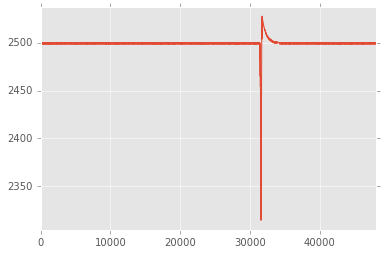

In [37]:
mpl.plts(pmtrwf[0,0], signal_start=0, signal_end=48000, offset=10)

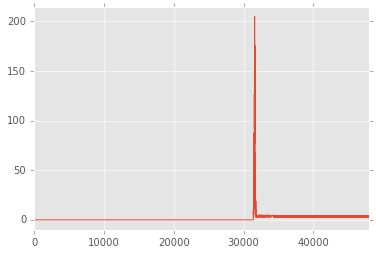

In [38]:
mpl.plts(pmtcwf[0,0], signal_start=0, signal_end=48000, offset=10)

In [33]:
h5f.close()